In [1]:
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import yfinance as yf

In [2]:
sp500 = list(pd.read_csv('sp500_companies.csv')['Symbol'])

In [3]:
for tick in ['ANSS', 'DFS', 'JNPR', 'WBA', 'HES', 'PARA', 'GEV', 'SOLV', 'AMTM']:
    sp500.remove(tick)

In [ ]:
tickers = ['AAPL','NVDA','MSFT','AMZN','GOOGL','GOOG','META','TSLA','AVGO','BRK-B']

# Download data
data = yf.download(tickers, start="2022-01-01", end="2024-01-01")["Close"]

# Drop missing rows
data = data.dropna(how='any')

# Daily log returns
returns = np.log(data / data.shift(1)).dropna(how='any')

# Correlation matrix
corr = returns.corr().values

[*********************100%***********************]  10 of 10 completed


In [28]:
def spectral_clustering_with_threshold(corr_matrix, threshold, n_clusters):
    G = nx.Graph()
    for i, ticker in enumerate(tickers):
        G.add_node(i, label=ticker)

    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            if corr_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
                
    node_features = []

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        subgraph = G.subgraph(neighbors + [node])

        degree = G.degree(node)
        strength = sum([G[node][nbr]['weight'] for nbr in neighbors])
        clustering = nx.clustering(G, node, weight='weight')
        loops = sum(1 for cycle in nx.cycle_basis(subgraph) if node in cycle)

        node_features.append([degree, strength, clustering, loops])

    node_features = np.array(node_features)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(node_features)

    # Create similarity matrix using RBF kernel
    similarity_matrix = rbf_kernel(X_scaled, gamma=0.5)

    # Spectral clustering
    sc = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        random_state=42
    )
    labels = sc.fit_predict(similarity_matrix)
    
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, seed=42, k=0.5)

    node_sizes = 100 + 25 * node_features[:,3]  # loop count
    node_colors = labels  # cluster color

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set2)

    # Draw edges with correlation weight as thickness
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos,
        width=[4 * abs(d['weight']) for (_, _, d) in edges],  # use abs to scale thickness
        alpha=0.6
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels={i: tickers[i] for i in range(len(tickers))})

    plt.title("Correlation-Weighted Stock Graph with Threshold=0.6")
    plt.axis('off')
    plt.show()
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(node_features)
    
    plt.figure(figsize=(12,9))

    # Scatter plot, colored by cluster
    for cluster_id in np.unique(labels):
        idx = labels == cluster_id
        plt.scatter(
            X_pca[idx,0],
            X_pca[idx,1],
            label=f'Cluster {cluster_id}',
            s=300,
            alpha=0.7
        )

    # Annotate with tickers
    for i, ticker in enumerate(tickers):
        plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, ticker, fontsize=9)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Stock Graph Features Projected via PCA")
    plt.legend()
    plt.grid(True)
    plt.show()


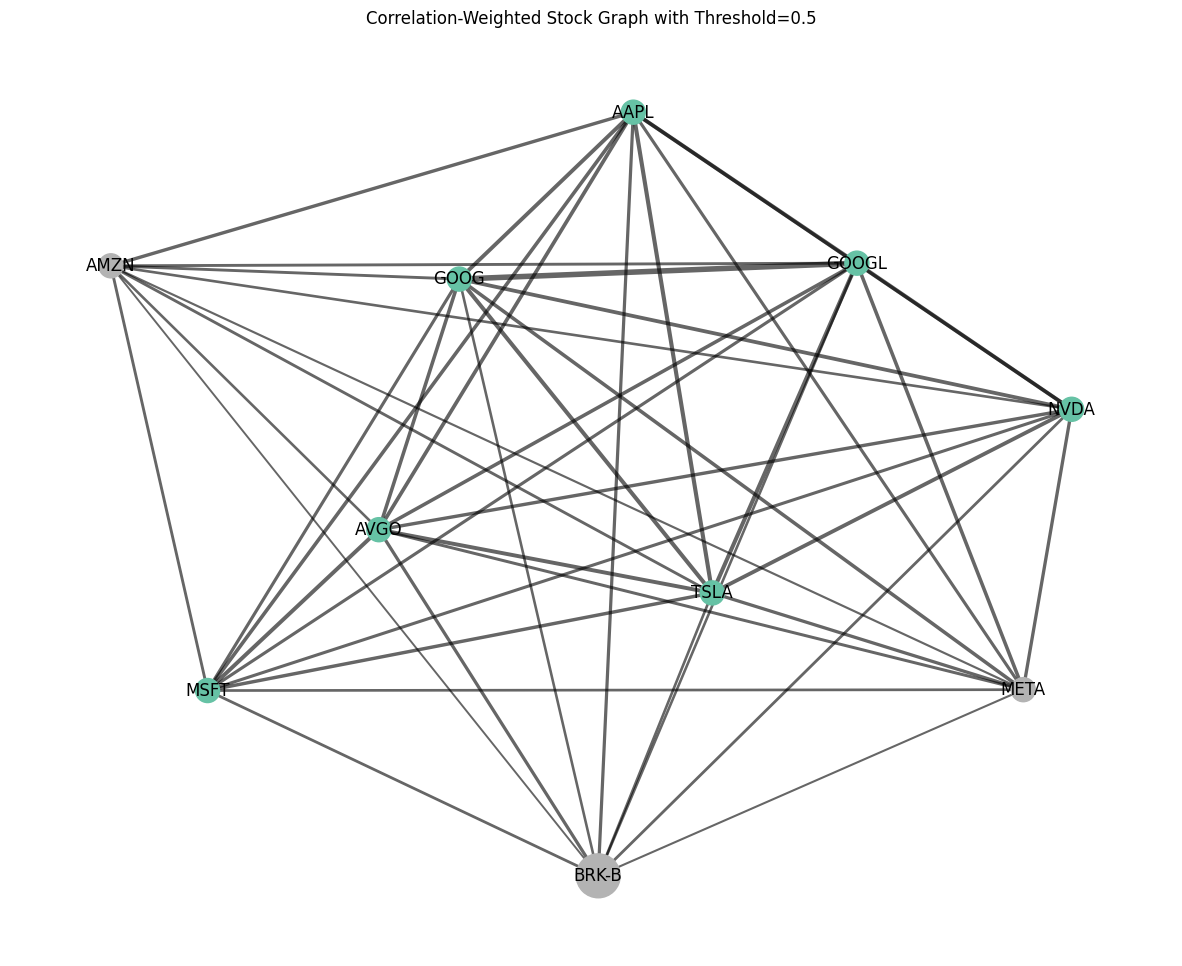

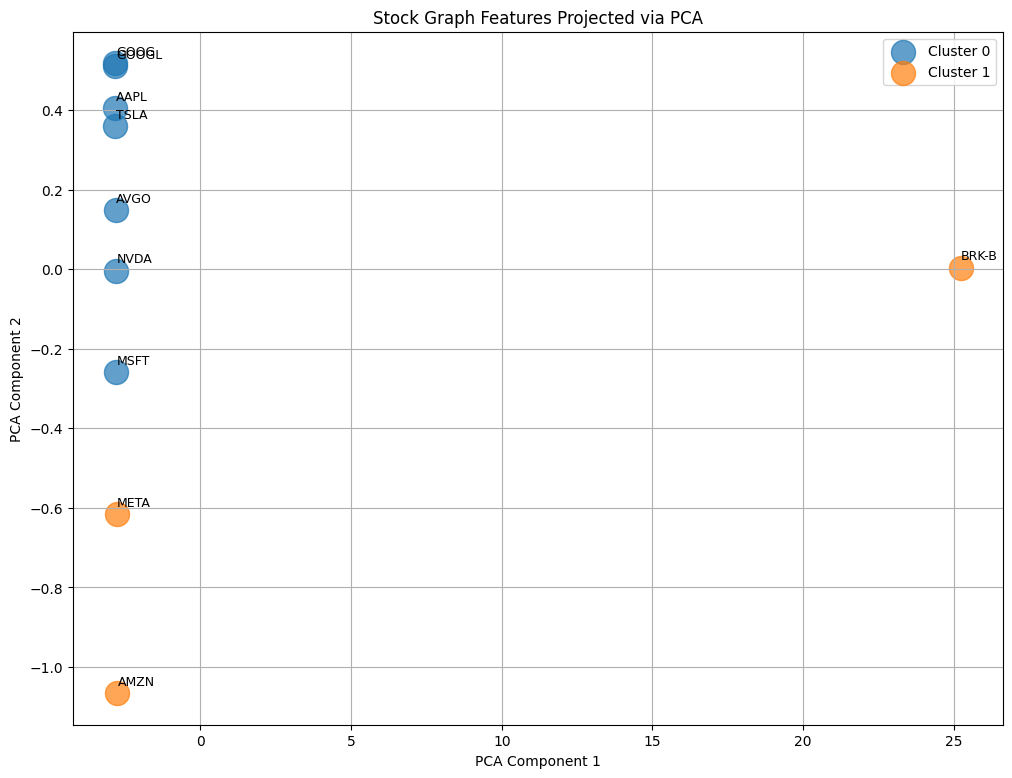

In [26]:
spectral_clustering_with_threshold(corr, threshold=0.3, n_clusters=2)

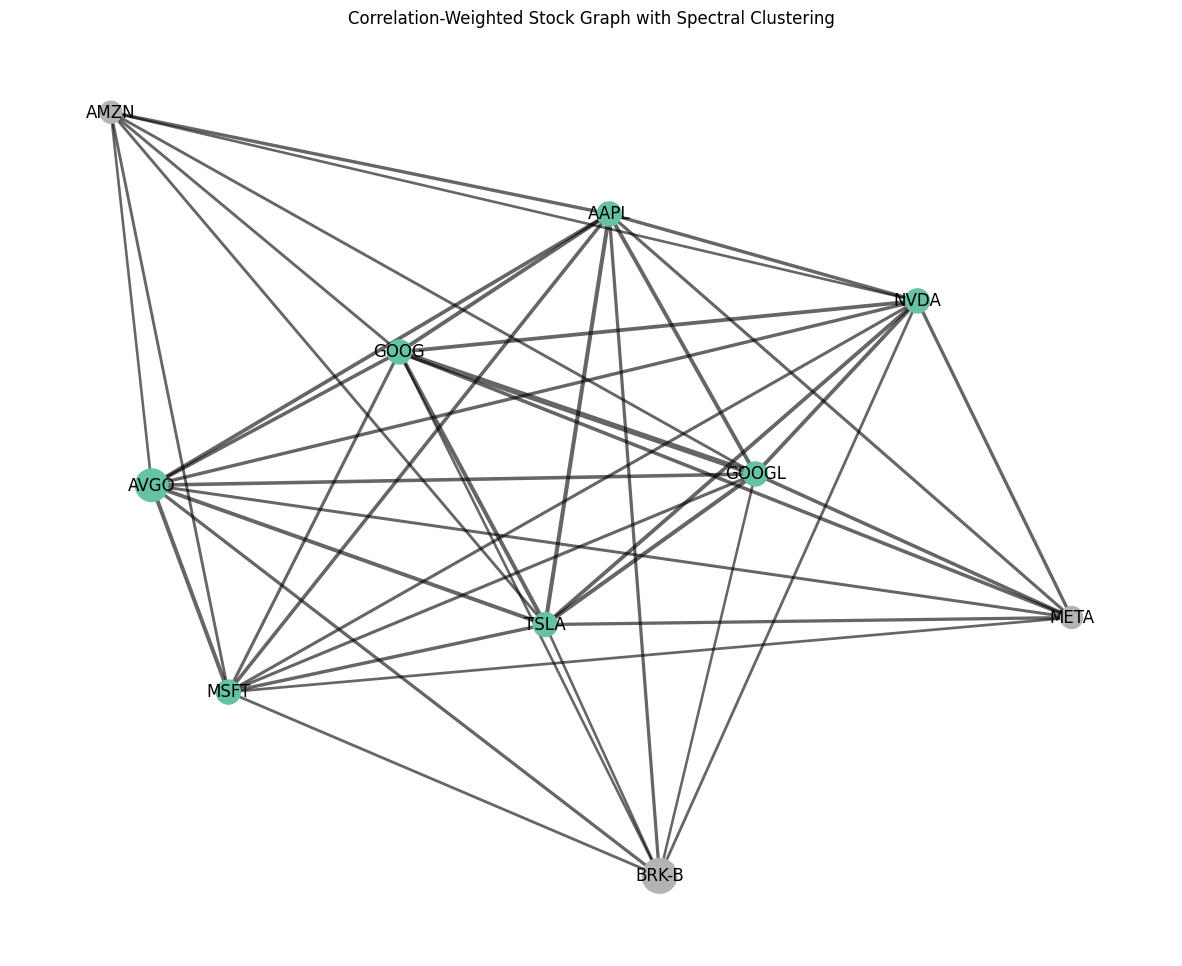

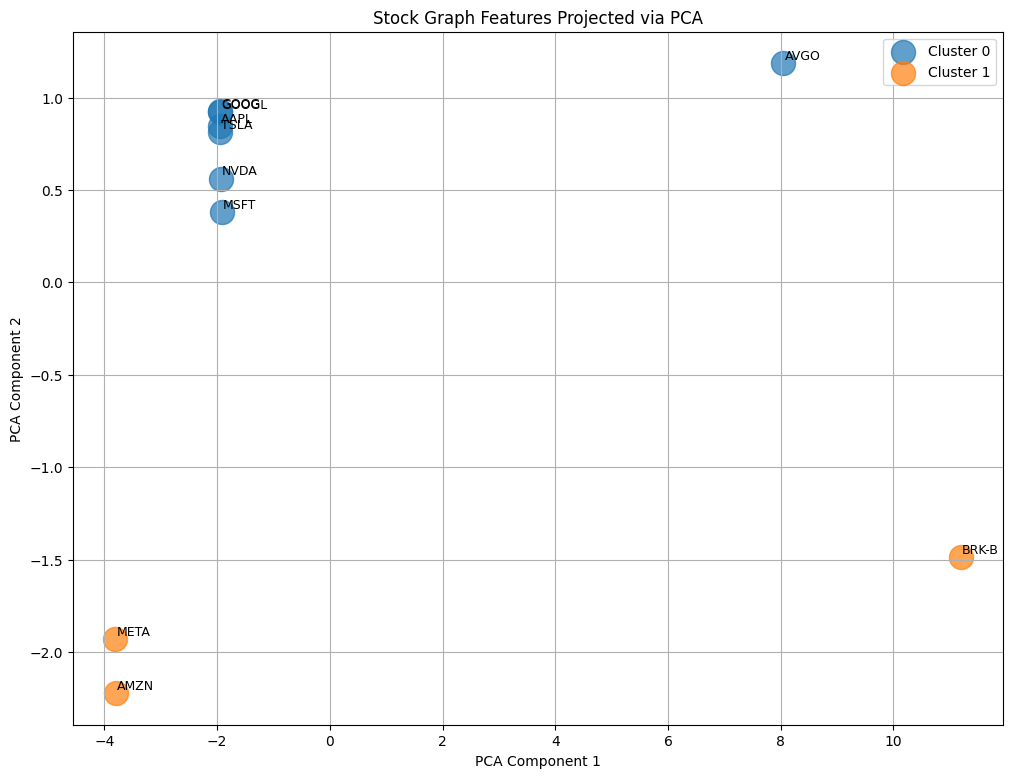

In [7]:
spectral_clustering_with_threshold(corr, threshold=0.4, n_clusters=2)

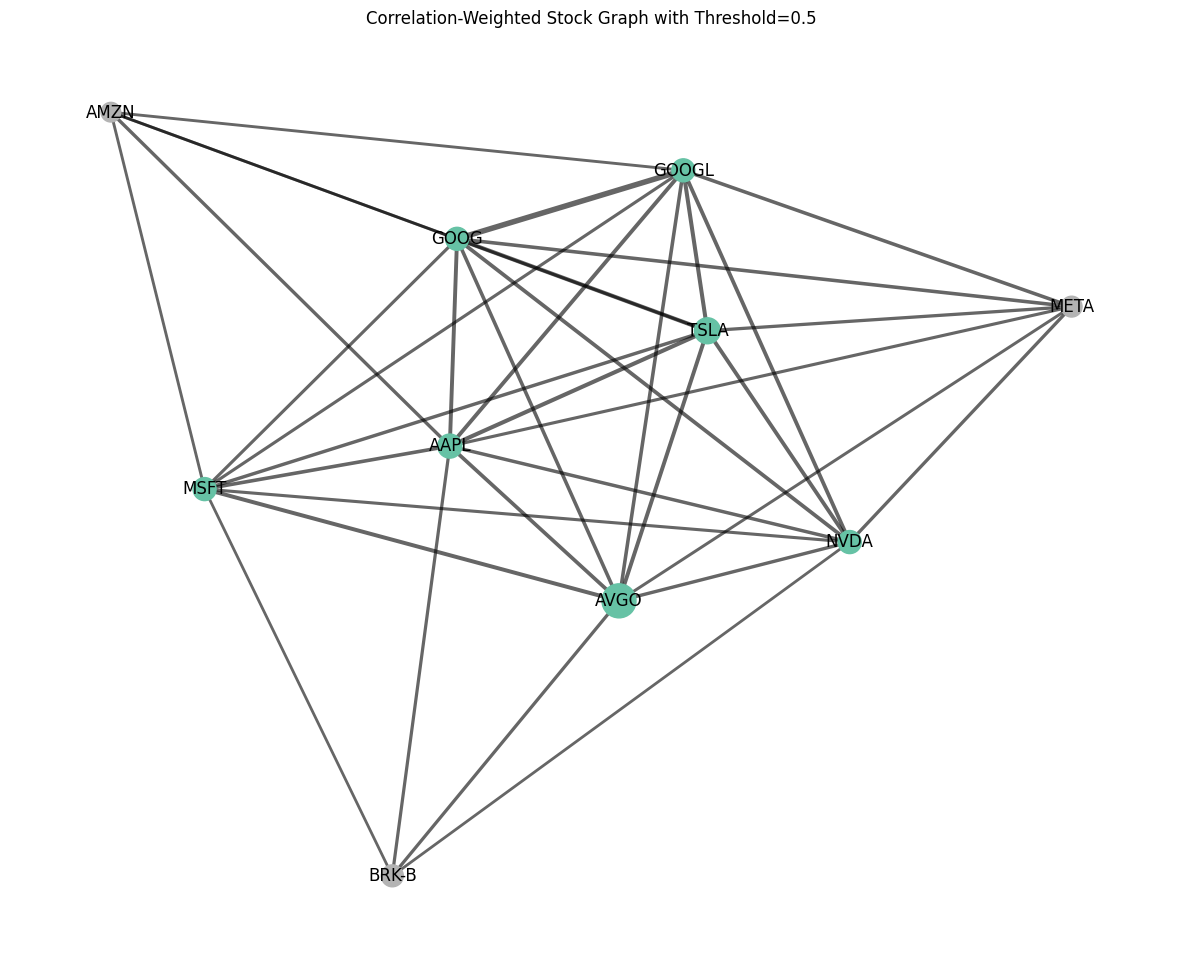

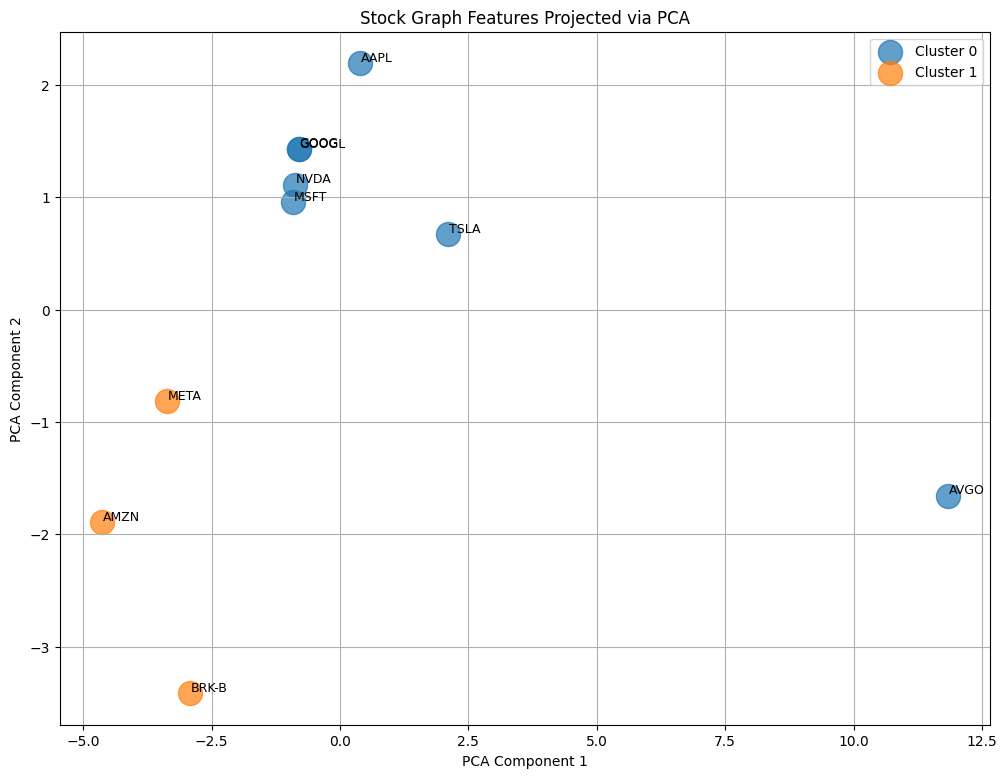

In [27]:
spectral_clustering_with_threshold(corr, threshold=0.5, n_clusters=2)

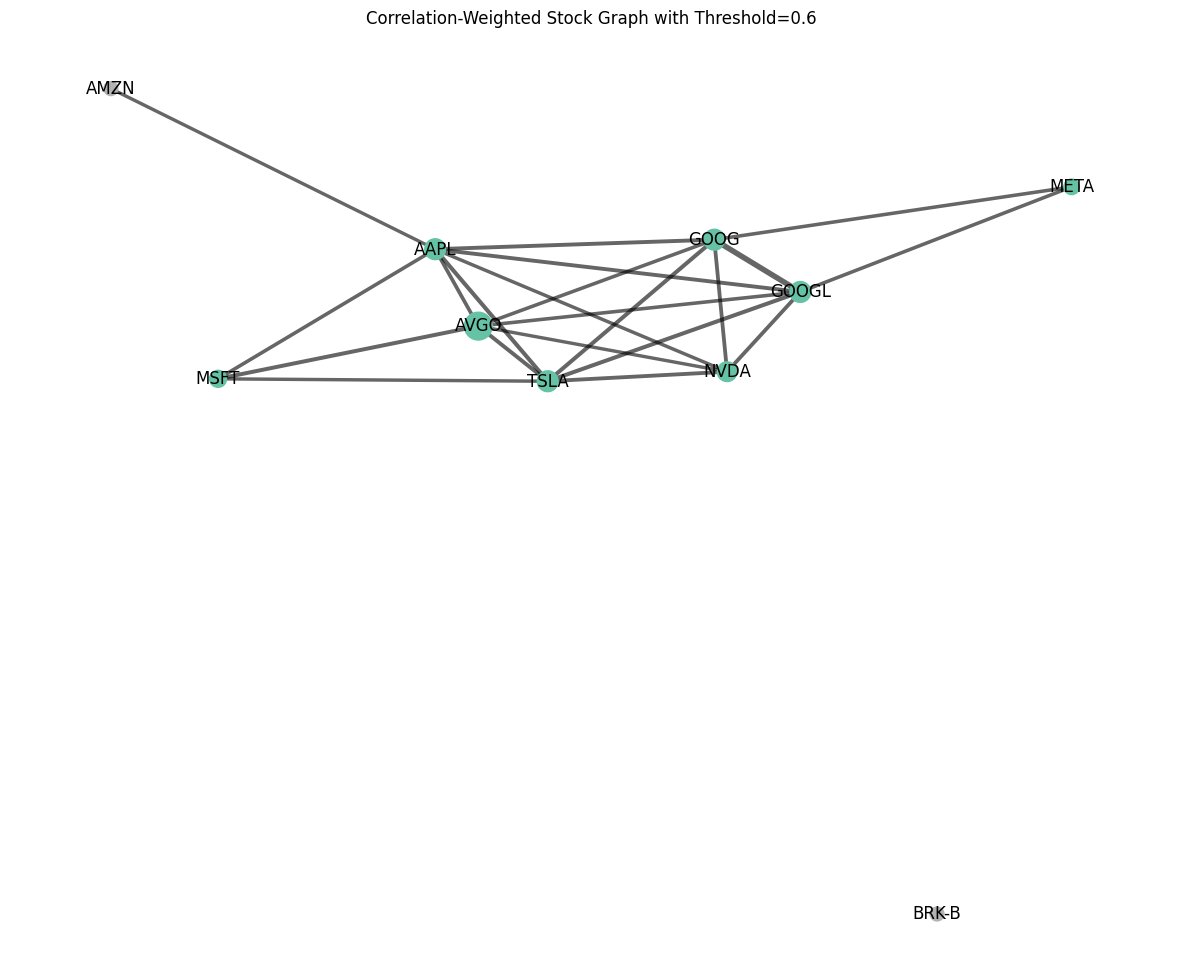

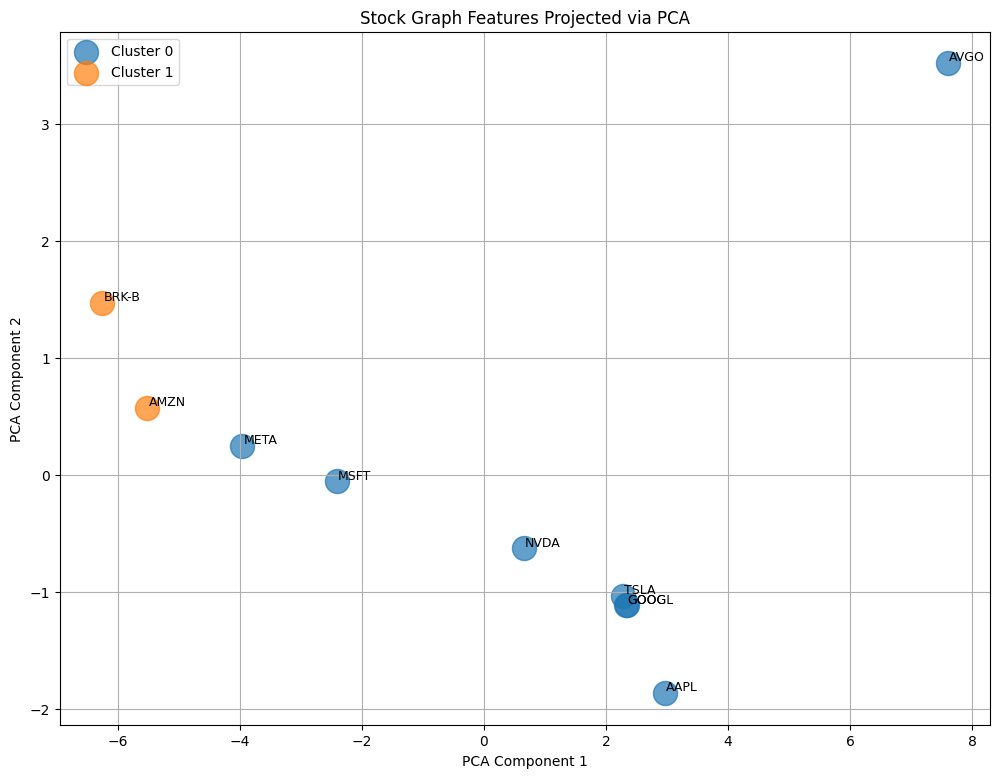

In [29]:
spectral_clustering_with_threshold(corr, threshold=0.6, n_clusters=2)

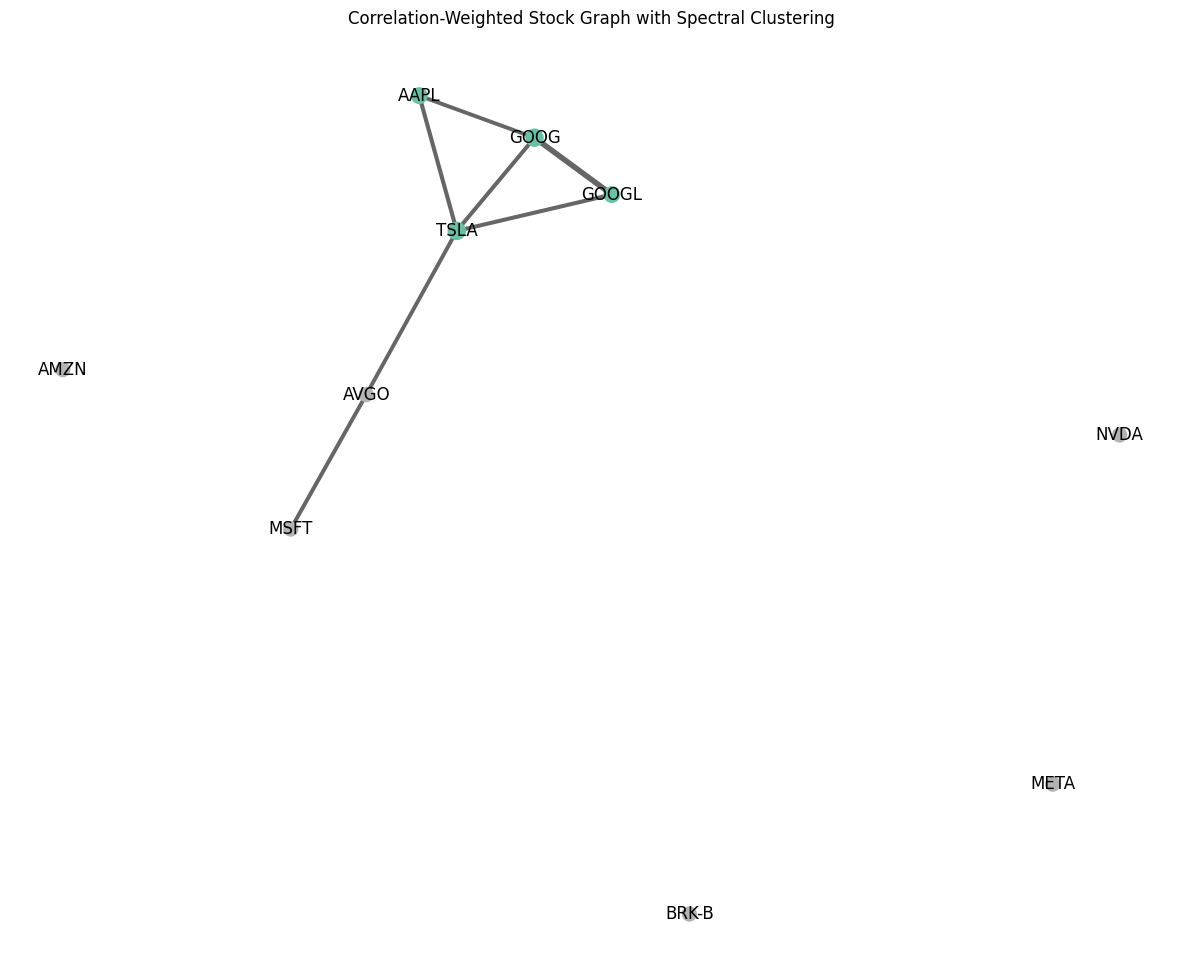

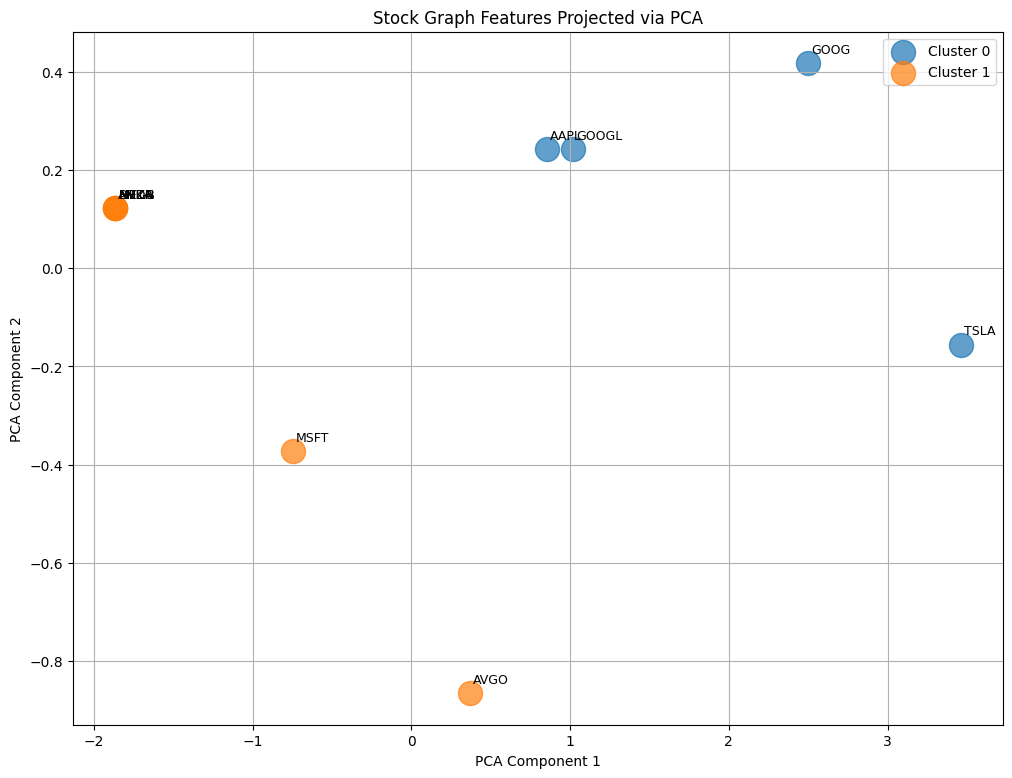

In [10]:
spectral_clustering_with_threshold(corr, threshold=0.7, n_clusters=2)

In [16]:
# spectral_clustering_with_threshold(corr, threshold=0.75, n_clusters=2)

In [17]:
# spectral_clustering_with_threshold(corr, threshold=0.8, n_clusters=2)

### Topological Data Analysis: Betti Numbers

In [54]:
threshold = 0.6

G = nx.Graph()
for i, t in enumerate(tickers):
    G.add_node(i, label=t)

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        if corr[i, j] >= threshold:
            G.add_edge(i, j)
            
st = gd.SimplexTree()

# vertices
for v in G.nodes():
    st.insert([v], 0.0)

# edges
for u, v in G.edges():
    st.insert([u, v], 0.0)

# triangles only (max dimension = 2)
for clique in nx.find_cliques(G):
    if len(clique) == 3:
        st.insert(clique, 0.0)

In [55]:
st.compute_persistence()

betti = st.betti_numbers()
print("Betti numbers:", betti)

Betti numbers: [2, 12]


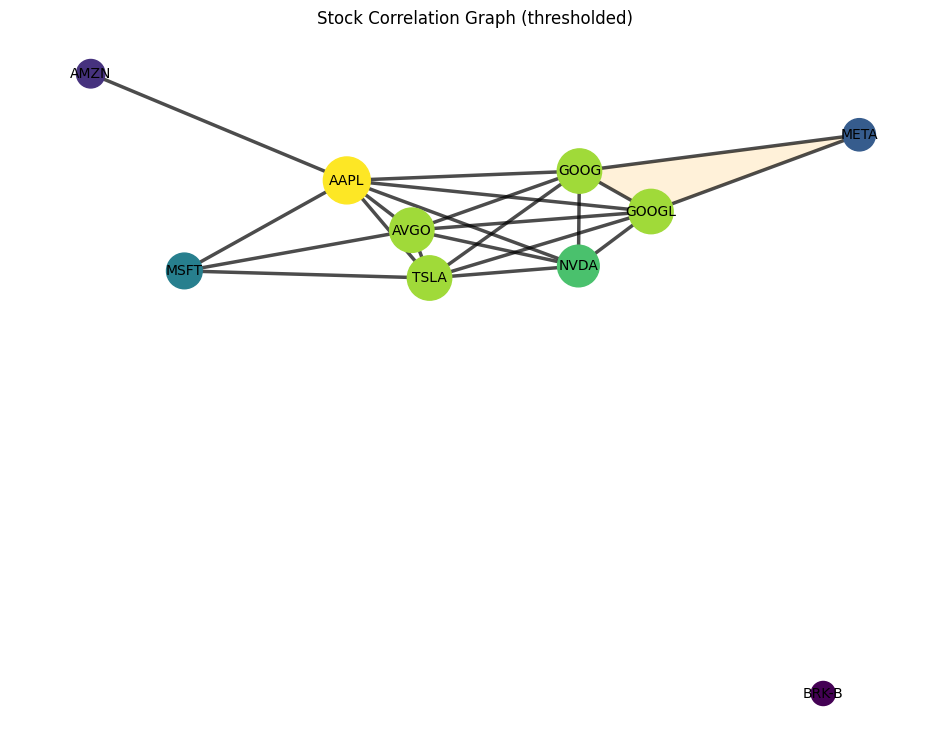

In [56]:
from matplotlib.patches import Polygon

pos = nx.spring_layout(G, seed=42, k=0.5)

# node visuals
degrees = np.array([G.degree(n) for n in G.nodes()])
node_sizes = 300 + 120 * degrees
node_colors = degrees

# edge visuals (use weight if present)
edge_weights = [G[u][v].get('weight', 1.0) for u, v in G.edges()]

plt.figure(figsize=(12,9))
# draw triangle faces first (semi-transparent)
for clique in nx.find_cliques(G):
    if len(clique) == 3:
        pts = [pos[n] for n in clique]
        poly = Polygon(pts, closed=True, facecolor='orange', alpha=0.15, edgecolor=None)
        plt.gca().add_patch(poly)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, width=[2.5 * abs(w) for w in edge_weights], alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n: tickers[n] for n in G.nodes()}, font_size=10)
plt.title("Stock Correlation Graph (thresholded)")
plt.axis('off')
plt.show()

In [58]:
cycles = nx.cycle_basis(G)
print("Cycles:", cycles)
print("Number of cycles:", len(cycles))

Cycles: [[0, 7, 8], [1, 7, 8], [2, 7, 8], [4, 7, 8], [5, 7, 8], [0, 5, 8], [1, 5, 8], [4, 5, 8], [4, 6, 5], [0, 4, 8], [1, 4, 8], [0, 2, 8], [0, 1, 8]]
Number of cycles: 13


In [59]:
# Suppose G is thresholded correlation graph
cycles = nx.cycle_basis(G)
beta1_estimate = len(cycles)  # rough H1 estimate
print("Estimated number of loops (H1):", beta1_estimate)


Estimated number of loops (H1): 13
